In [24]:
# This file contains functions for:
# song fingerprinting (finding peaks)
# fingerprint comparision (comparing peaks to those looked up in the database_
# determining the best match for a song sample
# determining whether the best match is sufficient to identify the song

import numpy as np
import itertools
import collections
# the imports below could be removed if you didn't wanna visualize things!
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.morphology import iterate_structure

In [42]:
def find_peaks(song):
    """
    Find the peaks in the two-dimensional array that describes a song
    Parameters:
    ----------
    song: numpy.ndarray (MxN)
        the two dimensional array of Fourier-constants describing the song
        song[i,j] is the magnitude of the Fourier-constant for frequency i at time j
    Returns:
    --------
    peaks: binary array (MxN)
        the binaray "mask" that identifies the locations of peaks
        peaks[i,j] is True if there is a local peak for frequency i at time j 
    """
    #generates proper neighborhood
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 20)  # this incorporates roughly 20 nearest neighbors
    #finds foreground
    ys, xs = np.histogram(song.flatten(), bins=len(freqs)//2, normed=True)
    dx = xs[-1] - xs[-2]
    cdf = np.cumsum(ys)*dx  # this gives you the cumulative distribution of amplitudes
    cutoff = xs[np.searchsorted(cdf, 0.77)]
    foreground =  (song >= cutoff)
    #generates boolean array of peaks that are both peaks and in the foreground
    peaks = np.logical_and((song == maximum_filter(song, footprint=neighborhood)), foreground)
    return peaks

In [82]:
def find_fingerprint(peaks, freqs, times):
    """
    Find the features (which are each a tuple of two peaks and the distance between them) of a song based on its peaks
    Parameters:
    ----------
    peaks: binary array (MxN)
        the binary "mask" that identifies the locations of peaks
        peaks[i,j] is True if there is a local peak for frequency i at time j
    freqs: float array (MxN)
        the array in which freqs[k] is the real value of the frequency value in bin k
    times: float array (MxN)
        the array in which time[k] is the real value of the time value in bin k
    Returns:
    --------
    song_fp: list of tuples (arbitrary length, all peaks in the song)
        the list of of tuples tuples of length three, each containing with two peaks and the distance between the two peaks
        of the form ((f1,f2,delta t), t1)
    """
    print(freqs.shape)
    print(times.shape)
    song_fp_t = []
    indices = np.argwhere(peaks == True)
    print(indices.shape)
    comparisons = itertools.combinations(indices, 2)
    threshold = 15
    filtered = itertools.filterfalse(lambda x: abs(times[x[1][1]]- times[x[0][1]]) > threshold, comparisons)
    for (f1, t1), (f2,t2) in filtered:
        #print((f1, t1),(f2,t2))
        song_fp_t.append(tuple([tuple([round(freqs[f1],2), round(freqs[f2],2), round(abs(times[t2] - times[t1]),2)]), round(times[t1],2)]))
    print(len(song_fp_t))
    return song_fp_t

In [36]:
def get_matches(sample_fp_t, db):
    """
    Find the features (which are each a tuple of two peaks and the distance between them) of a song based on its peaks
    Parameters:
    ----------
    sample_fp: list of tuples (arbitrary length, all peaks in the sample)
        the list of tuples of length three, each containing with two peaks and the distance between the two peaks 
    db: dictionary
        the dictionary with features as keys and song names as values
    Returns:
    --------
    matches: list of tuples of song ids and time differences 
        the list of song ids in the database that share features with the supplied sample
        and the amount of time between the feature occuring in the sample and in the 
    """
    matches = []
    for feat in sample_fp_t:
        if feat[0] in db: #feat[0] is the actual finger print of the form (f1,f2,delta t)
            match = db.get(feat[0])
            matches += tuple(match[0], round(match[1] - feat[1])) #feat[1] is the time at which the feature occurs
    return matches

In [37]:
def best_match(matches):
    """
    Find the features (which are each a tuple of two peaks and the distance between them) of a song based on its peaks
    Parameters:
    ----------
    matches: list of song names
        the list of song names in the database that share features with the supplied sample    Returns:
    --------
    best_match: song name
        the song name that occurs the most frequently in the list
    """
    c = Counter(x[0] for x in matches)
    best_matches = c.most_common(2)
    threshold = 20
    if c.get(best_matches[0]) - c.get(best_matches[1]) < threshold:
        return "Not found"
    return best_matches[0]

<IPython.core.display.Javascript object>


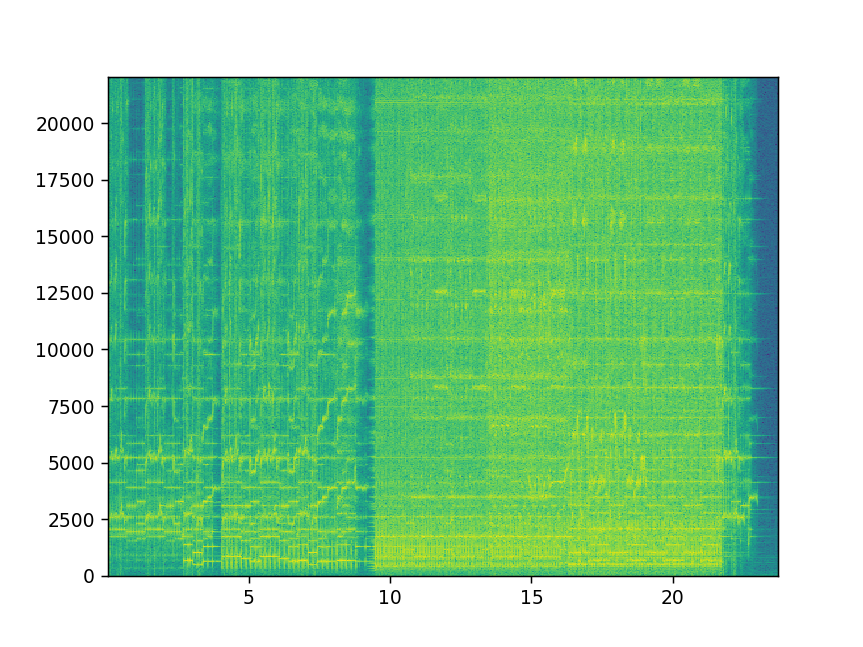

In [38]:
#testing
import librosa
samples_42, fs = librosa.load(r"C:\Users\Jaden\Dropbox\COG\Songs\42-_Coldplay_.mp3", sr=44100, mono=True)

import matplotlib.pyplot as plt
%matplotlib notebook


fig, ax = plt.subplots()
S, freqs, times, im = ax.specgram(samples_42[::10], NFFT=4096, Fs=fs, window=mlab.window_hanning, noverlap=(4096 // 2))

In [83]:
v = find_fingerprint(find_peaks(S), freqs, times)
v

(2049,)
(510,)
(759, 2)
253473


[((10.77, 32.299999999999997, 8.1300000000000008), 15.050000000000001),
 ((10.77, 43.07, 11.800000000000001), 15.050000000000001),
 ((10.77, 86.129999999999995, 13.369999999999999), 15.050000000000001),
 ((10.77, 441.43000000000001, 5.3899999999999997), 15.050000000000001),
 ((10.77, 441.43000000000001, 2.79), 15.050000000000001),
 ((10.77, 441.43000000000001, 0.93000000000000005), 15.050000000000001),
 ((10.77, 441.43000000000001, 0.14000000000000001), 15.050000000000001),
 ((10.77, 452.19999999999999, 14.58), 15.050000000000001),
 ((10.77, 516.79999999999995, 1.8600000000000001), 15.050000000000001),
 ((10.77, 516.79999999999995, 2.9700000000000002), 15.050000000000001),
 ((10.77, 516.79999999999995, 5.6200000000000001), 15.050000000000001),
 ((10.77, 527.55999999999995, 4.1799999999999997), 15.050000000000001),
 ((10.77, 592.15999999999997, 14.949999999999999), 15.050000000000001),
 ((10.77, 656.75999999999999, 9.75), 15.050000000000001),
 ((10.77, 689.05999999999995, 12.31), 15.050

In [10]:
fp = generate_binary_structure(rank=2,connectivity=1)
fp = iterate_structure(fp, 10)

<IPython.core.display.Javascript object>


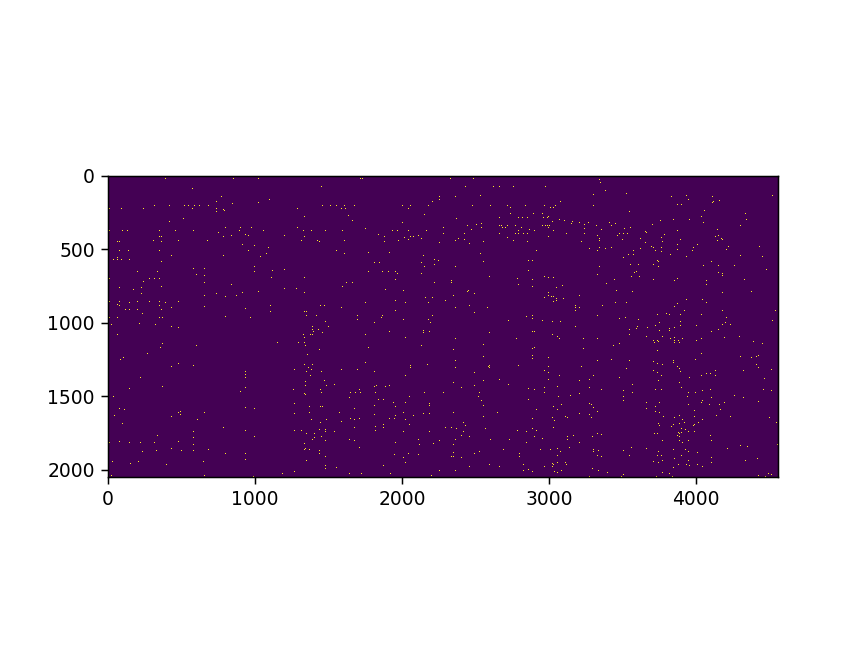

In [11]:
fig, ax = plt.subplots()
ax.imshow(find_peaks(S, fp))

In [18]:
len(v)

1687